In [1]:
!pip install natsort

Import Libraies

In [2]:
# test_imports.py

import os
import cv2
import random
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted
from os import makedirs, listdir
from os.path import join, isdir
from PIL import Image, ImageChops, ImageEnhance

import numpy as np
np.random.seed(2)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from sklearn.metrics import confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import (
    MobileNetV2, Xception, InceptionV3, EfficientNetB7, ResNet101, NASNetLarge, 
    VGG19, VGG16, DenseNet201
)
from tensorflow.keras.applications import (
    mobilenet_v2, xception, inception_v3, efficientnet, resnet, nasnet, vgg19, 
    vgg16, densenet
)

print("All imports were successful!")


All imports were successful!


models

In [3]:
# Define available models
models = {
    'densenet': DenseNet201,
    'xception': Xception,
    'inceptionv3': InceptionV3,
    'efficientnetb7': EfficientNetB7,
    'vgg19': VGG19,
    'vgg16': VGG16,
    'nasnetlarge': NASNetLarge,
    'mobilenetv2': MobileNetV2,
    'resnet': ResNet101
}

# Define preprocessing functions for each model
preprocess = {
    'densenet': densenet.preprocess_input,
    'xception': xception.preprocess_input,
    'inceptionv3': inception_v3.preprocess_input,
    'efficientnetb7': efficientnet.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'vgg16': vgg16.preprocess_input,
    'nasnetlarge': nasnet.preprocess_input,
    'mobilenetv2': mobilenet_v2.preprocess_input,
    'resnet': resnet.preprocess_input
}

Computing Error Rate Analysis

In [4]:
# Error Level Analysis (ELA) Functions
def compute_ela_cv(path, quality=95, scale=15):
    """
    Computes the ELA (Error Level Analysis) for an image.
    
    Args:
        path (str): Path to the image file.
        quality (int): JPEG quality for compression.
        scale (int): Scale factor for difference visualization.
    
    Returns:
        np.ndarray: ELA difference image.
    """
    temp_filename = 'temp_file_name.jpg'
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # Save the image with specified JPEG quality
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Read the compressed image
    compressed_img = cv2.imread(temp_filename)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)

    # Compute absolute difference and scale
    diff = scale * cv2.absdiff(orig_img, compressed_img)
    diff = np.clip(diff, 0, 255).astype(np.uint8)
    return diff


def convert_to_ela_image(path, quality=95, scale=15):
    """
    Converts an image to its ELA (Error Level Analysis) representation.
    
    Args:
        path (str): Path to the image file.
        quality (int): JPEG quality for compression.
        scale (int): Scale factor for difference visualization.
    
    Returns:
        PIL.Image: ELA difference image.
    """
    temp_filename = 'temp_file_name.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale_factor = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale_factor)
    return ela_image


# Function to randomly sample an image from a directory
def random_sample(path, extension=None):
    """
    Randomly samples an image from the specified directory.
    
    Args:
        path (str): Directory path to sample from.
        extension (str, optional): File extension to filter. Defaults to None.
    
    Returns:
        str: Path to the sampled image.
    """
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
    if not items:
        raise ValueError(f"No files found in {path} with extension {extension}")
    p = random.choice(items)
    return p.as_posix()


Test on a Authentic image

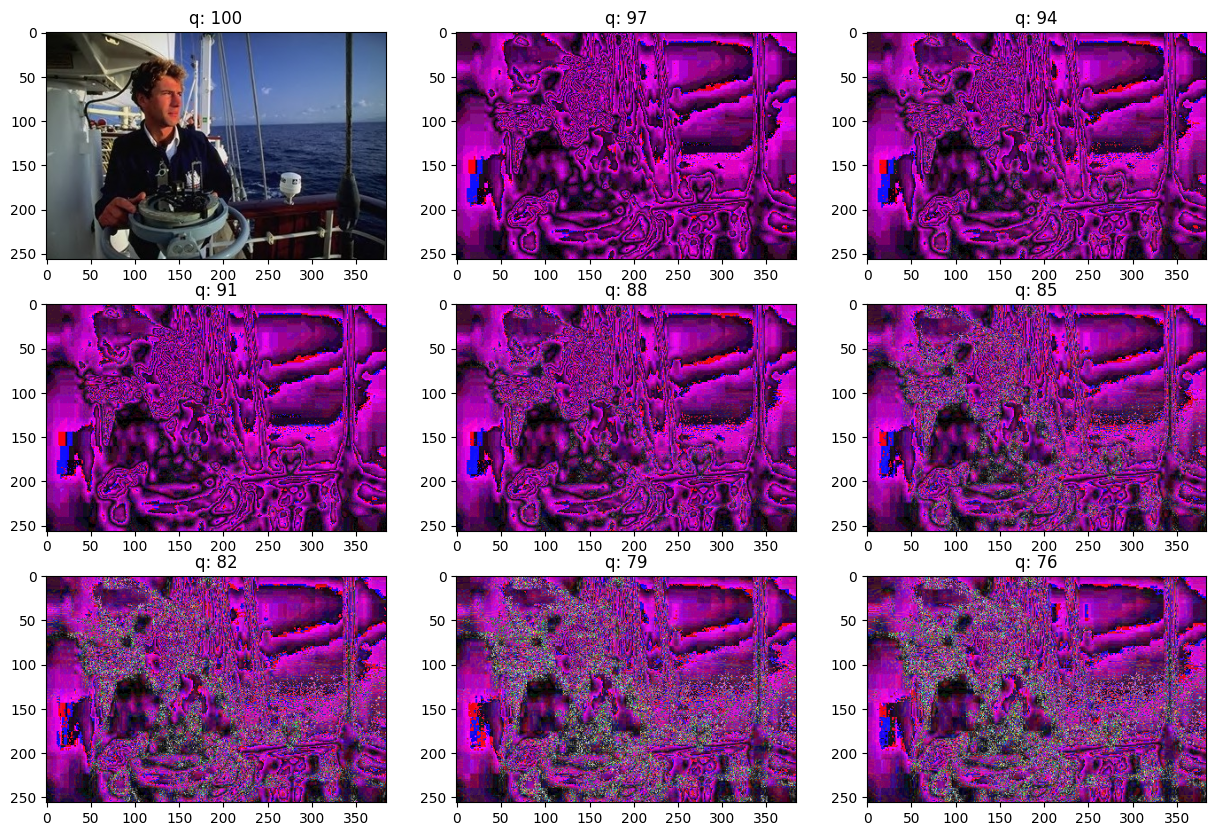

In [6]:
p = random_sample('input/casia-dataset/CASIA2/Au/')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig = plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality = init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Test on a tampered-fake image

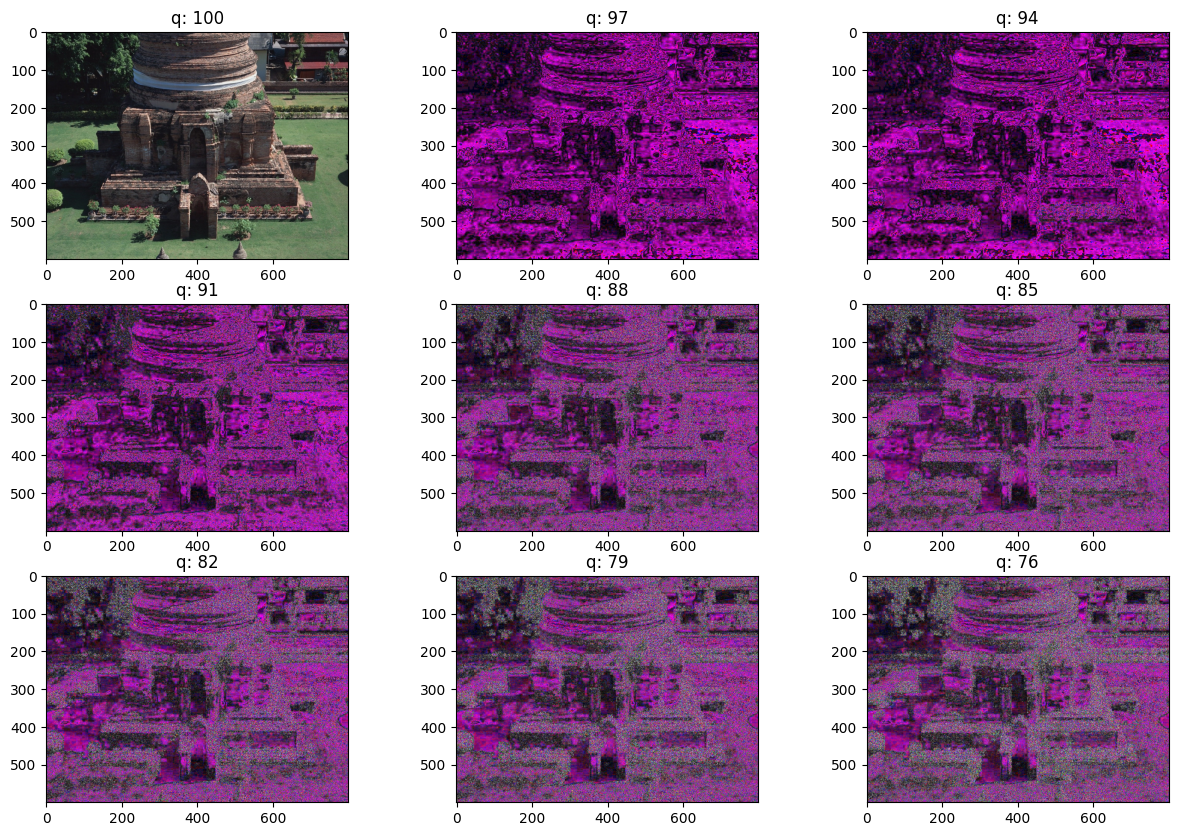

In [7]:
p = random_sample('input/casia-dataset/CASIA2/Tp/')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig = plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality = init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Test on a spliced-fake image

In [8]:
@tf.function
def tensor_aug(img):
    """
    Applies random augmentations to an image tensor.
    
    Args:
        img (tf.Tensor): Image tensor.
    
    Returns:
        tf.Tensor: Augmented image tensor.
    """
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    img = tf.image.random_saturation(img, lower=0.95, upper=1.05)
    img = tf.image.random_hue(img, max_delta=0.05)
    return img

@tf.function
def batch_aug(images, labels):
    """
    Applies augmentations to a batch of images.
    
    Args:
        images (tf.Tensor): Batch of image tensors.
        labels (tf.Tensor): Corresponding labels.
    
    Returns:
        tuple: Augmented images and labels.
    """
    images = tf.map_fn(lambda img: tensor_aug(img), images)
    return images, labels

def ela_process(file_path):
    """
    Processes an image file for ELA and prepares it for model training.
    
    Args:
        file_path (tf.Tensor): Path to the image file.
    
    Returns:
        tuple: Preprocessed image tensor and label.
    """
    QUALITY = 95
    SCALE = 15
    LABELS = np.array(['Au', 'Tp'])  # Authentic and Tampered

    parts = tf.strings.split(file_path, os.path.sep)
    label_str = parts[-2]
    label = tf.argmax(label_str == LABELS)
    label = tf.cast(label, tf.float32)

    # Read and preprocess the image
    orig = cv2.imread(file_path.numpy().decode('utf-8'))
    orig = cv2.resize(orig, (224, 224), interpolation=cv2.INTER_AREA)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig = orig.astype(np.float32) / 255.0

    # Apply ELA
    _, buffer = cv2.imencode(".jpg", orig * 255.0, [cv2.IMWRITE_JPEG_QUALITY, QUALITY])
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    # Compute absolute difference
    diff = SCALE * np.abs(orig - compressed_img)
    diff = np.clip(diff, 0, 1)  # Normalize

    # Apply preprocessing specific to the chosen model
    img = preprocess['xception'](diff)

    return img, label

In [9]:
jpg_pattern = 'input/casia-dataset/CASIA2/*/*jp*g'
tif_pattern = 'input/casia-dataset/CASIA2/*/*tif'

# List all image files
jpg_files = tf.data.Dataset.list_files(jpg_pattern, shuffle=False)
tif_files = tf.data.Dataset.list_files(tif_pattern, shuffle=False)

# Combine datasets
data_ds = jpg_files.concatenate(tif_files)

# Apply ELA processing
tensor_preprocess = lambda x: tf.py_function(ela_process, [x], [tf.float32, tf.float32])

# Shuffle and split dataset
n_data = data_ds.cardinality().numpy()
n_val = int(0.2 * n_data)
data_ds = data_ds.shuffle(buffer_size=n_data, reshuffle_each_iteration=False)

# Create training and validation datasets
train_ds = data_ds.skip(n_val).map(
    tensor_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
).batch(32).map(
    batch_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE
).prefetch(tf.data.experimental.AUTOTUNE)

val_ds = data_ds.take(n_val).map(
    tensor_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Inspect a batch of labels
for img, label in train_ds.take(1):
    print("Sample labels:", label.numpy())

Sample labels: [0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 0.]


##### Checking the generated images

Utility functions for Training and Evaluations

In [10]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')  # Precision-Recall Curve
]

def create_model(optimizer, name='xception', loss='binary_crossentropy'):
    """
    Creates and compiles the model based on the specified architecture.
    
    Args:
        optimizer (tf.keras.optimizers.Optimizer): Optimizer for training.
        name (str): Model architecture name.
        loss (str): Loss function.
    
    Returns:
        tf.keras.Model: Compiled Keras model.
    """
    base_model = models[name](include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model initially

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.inputs, outputs=output)
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)
    return model

# Initialize Optimizer
optimizer = Adam(learning_rate=1e-4)  # Changed to Adam with a lower learning rate

# Create the Model
model = create_model(optimizer, name='xception', loss='binary_crossentropy')
model.summary()

def scheduler(epoch):
    if epoch % 25 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.9)
        
    return K.get_value(model.optimizer.lr)

def generate_path(path_to_output, last_run=False):
    """
    Creates a new directory path for storing checkpoints and logs.
    
    Args:
        path_to_output (str): Base directory for outputs.
        last_run (bool, optional): Whether to retrieve the last run path. Defaults to False.
    
    Returns:
        str: Path to the new or existing run directory.
    """
    if not isdir(path_to_output):
        makedirs(path_to_output)
    
    runs = natsorted([path for path in listdir(path_to_output) if path.startswith("run_tf_data")])
    if last_run:
        if not runs:
            path = os.path.join(path_to_output, "run_tf_data_1")
        else:
            path = os.path.join(path_to_output, runs[-1])
        return path
    if not runs:
        path = os.path.join(path_to_output, 'run_tf_data_1')
    else:
        last_run_number = int(runs[-1].rsplit("run_tf_data_")[1])
        path = os.path.join(path_to_output, f'run_tf_data_{last_run_number + 1}')
    return path

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

Initializing the model

In [11]:
loss=tf.keras.losses.BinaryCrossentropy()
optimizer = SGD(learning_rate=1e-3, 
#                 decay=1e-6, 
                momentum=0.95, 
                nesterov=False)
"""
Model             Params
mobilenet           3M 
effecientnetb7      66M 
nasnetlarge         89M
inceptionv3         23M
xception            22M
resnet              44M
densenet            20M

"""


model = create_model(optimizer, name='xception', loss=loss)

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

Callbacks

In [13]:
path = generate_path('checkpoints')
weight_path = os.path.join(path, 'weights')
tensorboard_path = os.path.join(path, 'logs')

# Create Directories
makedirs(weight_path, exist_ok=True)
makedirs(tensorboard_path, exist_ok=True)

# Define Callbacks
ckpt = ModelCheckpoint(
    filepath=weight_path, 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=True
)

tensorboard = TensorBoard(
    log_dir=tensorboard_path, 
    write_graph=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

callbacks = [ckpt, tensorboard, reduce_lr, early_stop]

In [14]:
history = model.fit(
    train_ds,
    epochs=30,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/30
323/323 [==============================] - 276s 847ms/step - loss: 0.6811 - accuracy: 0.5797 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5021 - prc: 0.4177 - val_loss: 0.6806 - val_accuracy: 0.5807 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5515 - val_prc: 0.4605 - lr: 0.0010
Epoch 2/30
323/323 [==============================] - 270s 835ms/step - loss: 0.6795 - accuracy: 0.5797 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5238 - prc: 0.4414 - val_loss: 0.6803 - val_accuracy: 0.5807 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5931 - val_prc: 0.4974 - lr: 0.0010
Epoch 3/30
323/323 [==============================] - 269s 834ms/step - loss: 0.6785 - accuracy: 0.5797 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5381 - prc: 0.4545 - val_loss: 0.6803 - val_accuracy: 0.5807 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6046 - val_prc: 0.5034 - lr: 0.0010
Epoch 4/30
323/323 [=================

Evaluation

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

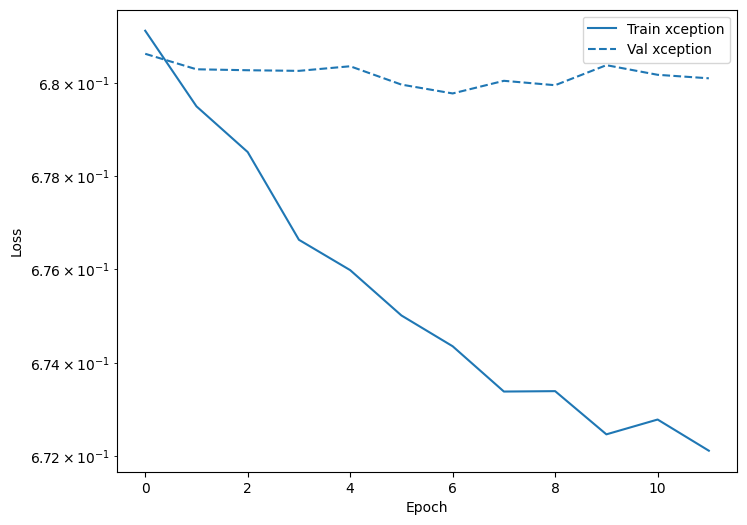

In [16]:
def plot_loss(history, label, n):
    """
    Plots the training and validation loss over epochs.
    
    Args:
        history (tf.keras.callbacks.History): Training history.
        label (str): Label for the plot.
        n (int): Color index.
    """
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history, 'xception', 0)
plt.show()

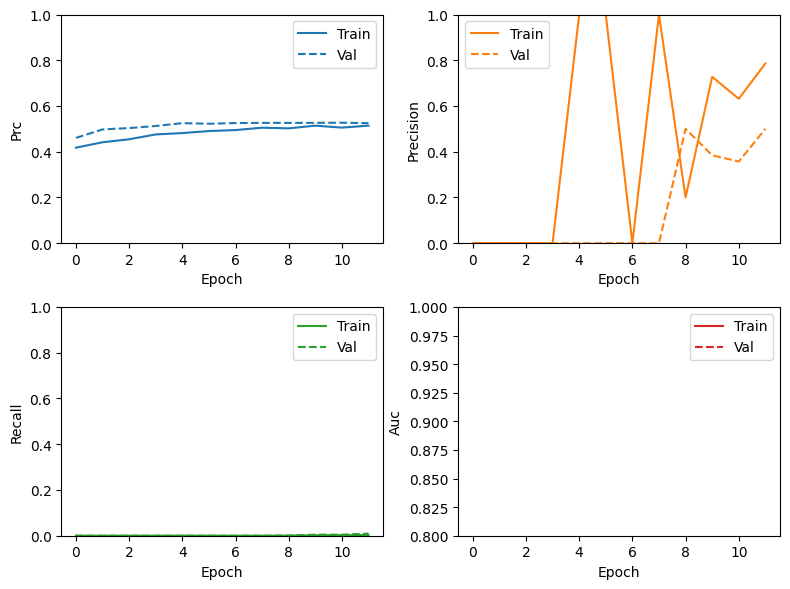

In [17]:
def plot_metrics(history):
    """
    Plots training and validation metrics over epochs.
    
    Args:
        history (tf.keras.callbacks.History): Training history.
    """
    metrics = ['prc', 'precision', 'recall', 'auc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[n], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[n], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(history)

In [18]:
val_ds_x = []
val_ds_y = []

for _, (val_x_batch, val_y_batch) in enumerate(val_ds):
    val_ds_x.append(val_x_batch)
    val_ds_y.append(val_y_batch)

val_data = (tf.concat(val_ds_x, axis=0), tf.concat(val_ds_y, axis=0))

print(f"Validation Data Shape: {val_data[0].shape}")

Validation Data Shape: (2583, 224, 224, 3)


81/81 [==============================] - 53s 646ms/step
loss : 0.6798
accuracy : 0.5807
precision : 0.0000
recall : 0.0000
auc : 0.6286
prc : 0.5254



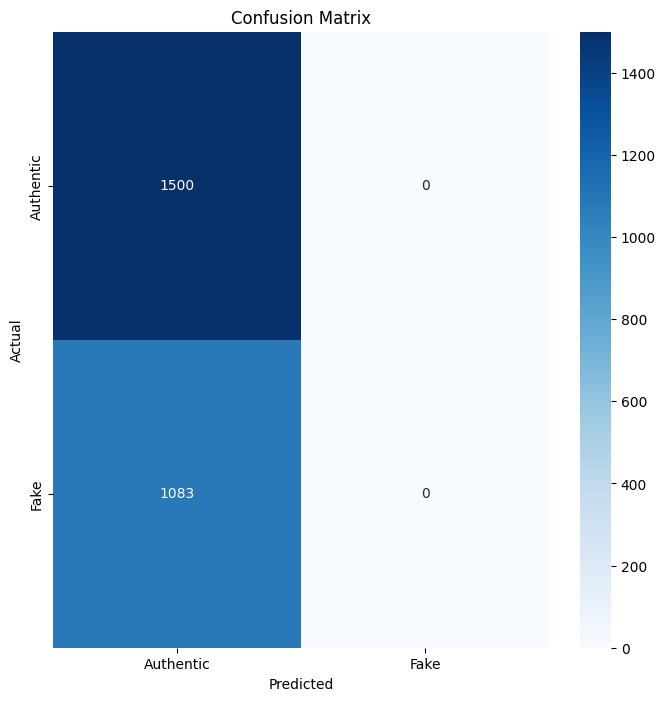

F1-Score: 0.0000


In [21]:
class_names = ['fake', 'authentic']

test_predictions_baseline = model.predict(val_data[0].numpy(), batch_size=32)


# Define Correct Confusion Matrix Plotting Function
def plot_cm(label_matrix, predictions, threshold=0.5):
    """
    Plots the confusion matrix.
    
    Args:
        label_matrix (np.ndarray): Ground truth labels.
        predictions (np.ndarray): Predicted probabilities.
        threshold (float, optional): Threshold to convert probabilities to class labels. Defaults to 0.5.
    """
    preds = (predictions > threshold).astype(int).squeeze()
    gt = label_matrix.astype(int).squeeze()
    
    cm = confusion_matrix(gt, preds, labels=[0, 1])  # 0: Authentic, 1: Fake
    class_names = ['Authentic', 'Fake']
    
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate Model on Validation Data
baseline_results = model.evaluate(val_data[0].numpy(), 
                                  val_data[1].numpy(),
                                  batch_size=32, 
                                  verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(f"{name} : {value:.4f}")
print()

# Plot Confusion Matrix
plot_cm(val_data[1].numpy(), test_predictions_baseline)

# Calculate and Print F1-Score
y_pred = (test_predictions_baseline > 0.5).astype(int).squeeze()
y_true = val_data[1].numpy().astype(int).squeeze()
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}")

In [24]:
model.save("detect_fake_img_model.h6_v2")

INFO:tensorflow:Assets written to: detect_fake_img_model.h6_v2\assets


INFO:tensorflow:Assets written to: detect_fake_img_model.h6_v2\assets


##### Fine Tune

Fine-Tuning the Model

In [ ]:
# Unfreeze the top layers of the base model for fine-tuning
base_model = model.layers[1]  # Assuming the base model is the second layer
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) - 50  # Adjust based on model architecture

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=METRICS)

# Continue training
history_fine = model.fit(
    train_ds,
    epochs=20,  # Additional epochs for fine-tuning
    callbacks=callbacks,
    validation_data=val_ds
)

Implementing F1-Score as a Metric

In [ ]:
# Custom F1-Score Metric
def f1_score_metric(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred_binary, 'float'), axis=0)
    predicted_positives = tf.reduce_sum(y_pred_binary, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1

# Add F1-Score to Metrics
METRICS.append(tf.keras.metrics.Mean(name='f1_score'))

def f1_update(y_true, y_pred):
    return f1_score_metric(y_true, y_pred)

# Re-compile the Model with Custom F1-Score
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=METRICS + [f1_update])

Leveraging TensorBoard for Monitoring

In [ ]:
# Load TensorBoard Extension (If using Jupyter Notebook)
%load_ext tensorboard
%tensorboard --logdir=checkpoints/run_tf_data_1/logs